# Compare 0.3 vs 0.5 threshold for paper

We realied (in SOS_threshold_comparison_4_paper) After removing the jump it is still possible to have big jumps in the regularized data. 

So, we created this new notebook.

In [17]:
# import warnings
# warnings.filterwarnings("ignore")

import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import scipy
import scipy.signal
import os, os.path

from datetime import date
import datetime
import time

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

import sys

In [18]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')
import remote_sensing_core as rc
import remote_sensing_plot_core as rcp

start_time = time.time()

In [19]:
data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/data_for_plots_in_paper/"
write_dir = "/Users/hn/Documents/01_research_data/remote_sensing/data_for_plots_in_paper/"

param_dir = "/Users/hn/Documents/00_GitHub/Ag/remote_sensing/parameters/"

In [20]:
indeks = "EVI"
given_county= "Grant"
SF_year = 2017

In [21]:
all_df = pd.read_csv(write_dir + "01_Regular_filledGap_Grant_SF_2017_EVI.csv", low_memory=False)

In [22]:
target_ID = "98574_WSDA_SF_2017"
a_df = all_df[all_df.ID == target_ID].copy()

a_df.sort_values(by=['image_year', 'doy'], inplace=True)

a_df.reset_index(drop=True, inplace=True)
a_df = a_df[a_df['EVI'].notna()]

In [23]:
if 'Date' in a_df.columns:
    if type(a_df.Date.iloc[0]) == str:
        a_df['Date'] = pd.to_datetime(a_df.Date.values).values


In [24]:
a_df = a_df[a_df['county'] == given_county.replace("_", " ")] # Filter Grant
a_df = rc.filter_out_NASS(a_df) # Toss NASS
a_df = rc.filter_by_lastSurvey(a_df, year = SF_year) # filter by last survey date
a_df['SF_year'] = SF_year


In [25]:
if not('DataSrc' in a_df.columns):
    print ("Data source is being set to NA")
    a_df['DataSrc'] = "NA"

if not('CovrCrp' in a_df.columns):
    print ("CovrCrp is being set to NA")
    a_df['CovrCrp'] = "NA"

CovrCrp is being set to NA


In [26]:
a_df = rc.initial_clean(df = a_df, column_to_be_cleaned = indeks)

In [27]:
an_EE_TS = a_df.copy()
del(a_df)

### List of unique polygons
polygon_list = np.sort(an_EE_TS['ID'].unique())


In [28]:
a_poly = target_ID

In [29]:
curr_field_two_years = an_EE_TS[an_EE_TS['ID'] == a_poly].copy()
curr_field_two_years.sort_values(by=['image_year', 'doy'], inplace=True)

In [30]:
def SG_1yr_clean_sciPy_SOS_fineGranularity(twoYears_regular, 
                                           idx, SG_params, SFYr, ax,
                                           onset_cut = 0.5, offset_cut = 0.5):
    """

    """
    ## crr_fld = dataAB.copy() #***
    crr_fld_twoYrs_regular = twoYears_regular.copy() #***
    if (not("human_system_start_time" in list(crr_fld_twoYrs_regular.columns))):
        crr_fld_twoYrs_regular = rc.add_human_start_time(crr_fld_twoYrs_regular)

    eleven_colors = ["gray", "lightcoral", "red", "peru", "darkorange", 
                     "gold", "olive", "green", "blue", "violet", "deepskyblue"]

    plant = crr_fld_twoYrs_regular['CropTyp'].unique()[0]
    #
    # Take care of names, replace "/" and "," and " " by "_"
    #
    plant = plant.replace("/", "_")
    plant = plant.replace(",", "_")
    plant = plant.replace(" ", "_")
    plant = plant.replace("__", "_")

    county = crr_fld_twoYrs_regular['county'].unique()[0]
    ID = crr_fld_twoYrs_regular['ID'].unique()[0]
    data_source = crr_fld_twoYrs_regular['DataSrc'].unique()[0]
    irrig_type = crr_fld_twoYrs_regular['Irrigtn'].unique()[0]
    survey_date = crr_fld_twoYrs_regular['LstSrvD'].unique()[0]

    ## y = crr_fld[idx].copy() #***
    ###
    ### Copy the regularized values that are processed up to SG smoothing.
    ###
    twoYrs_regular_Yvalues = crr_fld_twoYrs_regular[idx].copy()
    twoYrs_regular_Xvalues = crr_fld_twoYrs_regular['Date'].copy()

    #############################################
    ###
    ###             Smoothen
    ###
    #############################################
    # differences are minor, but lets keep using Pythons function
    window_len = SG_params[0]
    poly_order = SG_params[1]

    SG_pred_twoYears = scipy.signal.savgol_filter(twoYrs_regular_Yvalues, 
                                                  window_length= window_len, polyorder=poly_order)

    # SG might violate the boundaries. clip them:
    SG_pred_twoYears[SG_pred_twoYears > 1 ] = 1
    SG_pred_twoYears[SG_pred_twoYears < -1 ] = -1
    
    crr_fld_twoYrs_regular[idx] = SG_pred_twoYears
    
    # crr_fld will be one year from now on
    crr_fld = crr_fld_twoYrs_regular.copy()
    crr_fld = crr_fld[crr_fld.image_year == SFYr]
    #############################################
    ###
    ###             fine granularity table
    ###
    #############################################
    # create the full calenadr to make better estimation of SOS and EOS.
    fine_granular_table = rc.create_calendar_table(SF_year = SFYr)
    fine_granular_table = pd.merge(fine_granular_table, crr_fld, on=['Date', 'SF_year', 'doy'], how='left')

    ###### We need to fill the NAs that are created because they were not created in fine_granular_table
    fine_granular_table["image_year"] = crr_fld["image_year"].unique()[0]
    fine_granular_table["ID"]     = crr_fld["ID"].unique()[0]
    fine_granular_table["Acres"]  = crr_fld["Acres"].unique()[0]
    fine_granular_table["county"] = crr_fld["county"].unique()[0]

    fine_granular_table["CropGrp"] = crr_fld["CropGrp"].unique()[0]
    fine_granular_table["CropTyp"] = crr_fld["CropTyp"].unique()[0]
    fine_granular_table["DataSrc"] = crr_fld["DataSrc"].unique()[0]
    fine_granular_table["ExctAcr"] = crr_fld["ExctAcr"].unique()[0]

    fine_granular_table["IntlSrD"] = crr_fld["IntlSrD"].unique()[0]
    fine_granular_table["Irrigtn"] = crr_fld["Irrigtn"].unique()[0]

    fine_granular_table["LstSrvD"] = crr_fld["LstSrvD"].unique()[0]
    fine_granular_table["Notes"]   = crr_fld["Notes"].unique()[0]
    fine_granular_table["RtCrpTy"] = crr_fld["RtCrpTy"].unique()[0]
    fine_granular_table["Shap_Ar"] = crr_fld["Shap_Ar"].unique()[0]
    fine_granular_table["Shp_Lng"] = crr_fld["Shp_Lng"].unique()[0]
    fine_granular_table["TRS"] = crr_fld["TRS"].unique()[0]

    fine_granular_table = rc.add_human_start_time_by_YearDoY(fine_granular_table)

    # replace NAs with -1.5. Because, that is what the function fill_theGap_linearLine()
    # uses as indicator for missing values
    fine_granular_table.fillna(value={idx:-1.5}, inplace=True)
    
    fine_granular_table = rc.fill_theGap_linearLine(regular_TS = fine_granular_table, 
                                                    V_idx=idx, 
                                                    SF_year=SFYr)
    
    # update SG_pred so that we do not have to update too many other stuff.
    SG_pred = fine_granular_table[idx].values.copy()
    crr_fld = fine_granular_table
    y = fine_granular_table[idx].copy()
    #############################################
    ###
    ###   Form a data table of X and Y values
    ###
    #############################################

    if len(fine_granular_table['image_year'].unique()) == 2:
        X = rc.extract_XValues_of_2Yrs_TS(fine_granular_table, SF_yr = SFYr)
    elif len(fine_granular_table['image_year'].unique()) == 1:
        X = fine_granular_table['doy']

    d = {'DoY': X, 'Date': pd.to_datetime(fine_granular_table.human_system_start_time.values).values}
    date_df = pd.DataFrame(data=d)


    #############################################
    ###
    ###      Form a dictionary for plotting
    ###
    #############################################

    keyy = "SG: [" + str(window_len) + ", " + str(poly_order) + "]"
    plotting_dic = { keyy : [SG_pred]}

    #############################################
    ###
    ###             plot
    ###
    #############################################
    plot_title = county + ", " + plant + " (" + ID + ", " + \
                 data_source + ", " + irrig_type + ", " + survey_date +")" 
    
    plot_title = crr_fld_twoYrs_regular['CropTyp'].unique()[0]

    # plot SG smoothed version of two years
    ax.scatter(date_df.Date.values, y.values, label = "1-Day Time Series", s=7, c='b');

    ###
    ###   plot SOS and EOS
    ###
    # Update the EVI/NDVI values to the smoothed version.
    crr_fld [idx] = SG_pred
    crr_fld = rc.addToDF_SOS_EOS_White(pd_TS = crr_fld, 
                                       VegIdx = idx, 
                                       onset_thresh = onset_cut, 
                                       offset_thresh = offset_cut)

    ##
    ##  Kill bad detected seasons 
    ##
    crr_fld = rc.Null_SOS_EOS_by_DoYDiff(pd_TS = crr_fld, min_season_length=40)

    #
    #  Start of the season
    #
    SOS = crr_fld[crr_fld['SOS'] != 0]
    ax.scatter(SOS['Date'], SOS['SOS'], marker='+', s = 200, c='g')

    #
    #  End of the season
    #

    EOS = crr_fld[crr_fld['EOS'] != 0]
    ax.scatter(EOS['Date'], EOS['EOS'], marker='+', s = 200, c='r')

    # ax.axhline(0 , color = 'r', linewidth=.5)
    # ax.axhline(1 , color = 'r', linewidth=.5)
    # ax.axhline(-1, color = 'r', linewidth=.5)
    ax.axhline(onset_cut, color = 'r', linewidth=.5)
    
    # ax.set_ylim([-1.15, 1.15])
    ax.set_ylim([-0.2, 1.15])
    
    # annotate  SOS
    for ii in np.arange(0, len(SOS)):
        style = dict(size=10, color='grey', rotation='vertical')
        ax.text(x = SOS.iloc[ii]['Date'].date(), 
                # y = -0.95, 
                y = -0.15, 
                s = 'DoY=' + str(SOS.iloc[ii]['doy']), 
                **style)
        
    # annotate EOS
    for ii in np.arange(0, len(EOS)):
        style = dict(size=10, color='grey', rotation='vertical')
        ax.text(x = EOS.iloc[ii]['Date'].date(), 
                y = -0.15, 
                s = 'DoY=' + str(EOS.iloc[ii]['doy']), 
                **style)

    ax.set_title(plot_title);
    # ax.set(ylabel=idx)
    ax.legend(loc="best");

In [31]:
plant = curr_field_two_years['CropTyp'].unique()[0]
#
# Take care of names, replace "/" and "," and " " by "_"
#
plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")
plant = plant.replace("__", "_")

county = curr_field_two_years['county'].unique()[0]
ID = curr_field_two_years['ID'].unique()[0]


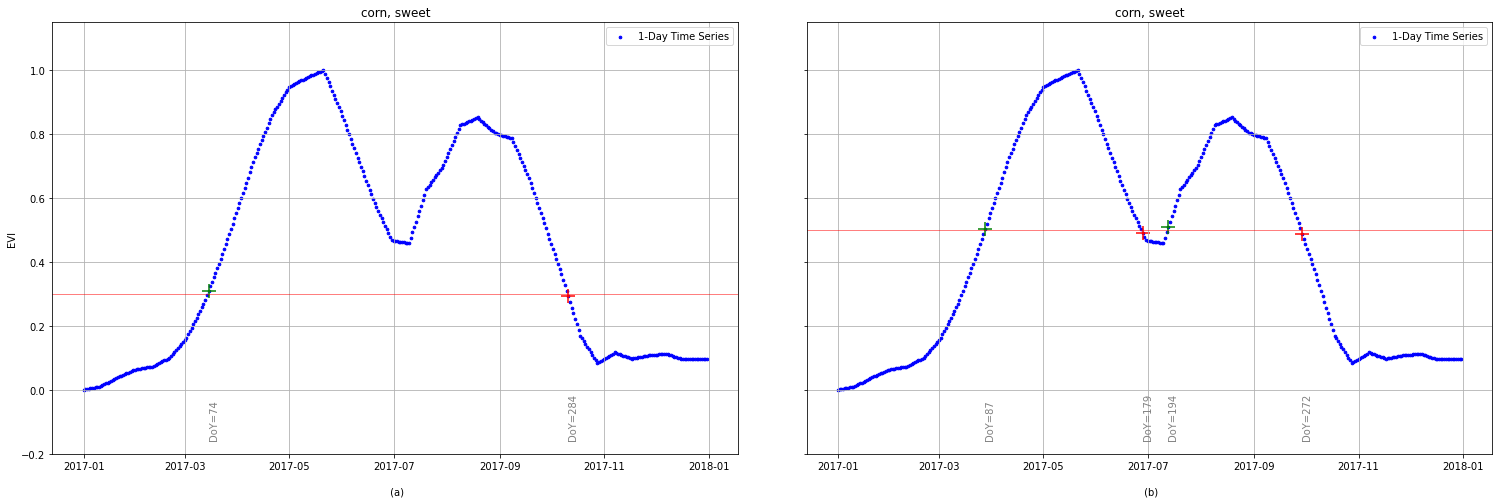

In [33]:
y_limits = [-0.2, 1.05]
fig, axs = plt.subplots(1, 2, figsize=(20, 6),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.2, 'wspace': .1});

(ax1, ax2) = axs;
ax1.grid(True); ax2.grid(True);
# plt.rcParams.update({'font.size': 22}) # changes titles font size

import matplotlib.pylab as pylab

# params = {'legend.fontsize': 'x-large',
#           #'figure.figsize': (15, 5),
#           'axes.labelsize': 18, # changes date (a), (b), (c), (d) on x-axis, EVI, NDVI on y axis. 
#                                # The smaller this number the bigger the labels!!
#           'axes.titlesize': 18, # changes titles, bean dry for example. 
#                                # This line and the one above are connected, problematic
#           'xtick.labelsize':14,
#           'ytick.labelsize':14
#          }
# pylab.rcParams.update(params)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

ax1.set(xlabel = '\n (a)', ylabel = indeks); # date\n (d)
ax1 = SG_1yr_clean_sciPy_SOS_fineGranularity(twoYears_regular = curr_field_two_years,
                                             idx = indeks, 
                                             SG_params = [7, 3], 
                                             SFYr = SF_year, ax = ax1,
                                             onset_cut = 0.3, 
                                             offset_cut = 0.3);

ax2.set(xlabel = '\n (b)', ylabel = ""); # date\n (d)
ax2 = SG_1yr_clean_sciPy_SOS_fineGranularity(twoYears_regular = curr_field_two_years,
                                             idx = indeks, 
                                             SG_params = [7, 3], 
                                             SFYr = SF_year, ax = ax2,
                                             onset_cut = 0.5, 
                                             offset_cut = 0.5);

plot_path = "/Users/hn/Documents/00_GitHub/Ag_papers/remote_sensing/plots_for_paper/"
os.makedirs(plot_path, exist_ok = True)

fig_name = plot_path + given_county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.pdf'
plt.savefig(fname = fig_name, dpi = 600, bbox_inches='tight')